In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Activation, Flatten, Dropout
from keras.optimizers import SGD
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
train_cols = ["Precipitation","Temperature","Outflow"]

In [4]:
new_df = df.filter(train_cols, axis=1)

In [5]:
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

In [6]:
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [7]:
lag_df = lag_seq(new_df, 2)
lag_df.dropna(inplace=True)

In [8]:
lag_df

,Precipitation,Temperature,Outflow,Outflow(t+1),Outflow(t+2)
0,0.0,102.992,5.0,5.0,5.0
1,0.0,97.790,5.0,5.0,5.0
2,0.0,92.588,5.0,5.0,5.0
3,0.0,87.404,5.0,5.0,5.0
4,0.0,85.172,5.0,5.0,5.0
...,...,...,...,...,...
185537,0.0,50.054,27.0,29.0,30.0
185538,0.0,52.880,29.0,30.0,29.0
185539,0.0,54.284,30.0,29.0,29.0
185540,0.0,55.670,29.0,29.0,31.0


In [9]:
#label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]
label_cols = ["Outflow(t+2)"]

In [10]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [11]:
#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [12]:
x_train.shape, y_test.shape

((148433, 3), (37109, 1))

In [13]:
y_train_actual = y_train
y_test_actual = y_test

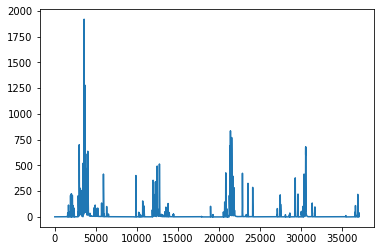

In [14]:
plt.figure()
plt.plot(y_test_actual)
plt.show()

In [15]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)

In [16]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



length of time-series i/o (148415, 18, 3) (148415,)



length of time-series i/o (37091, 18, 3) (37091,)


In [17]:
X_Train.shape,Y_Train.shape

((148415, 18, 3), (148415,))

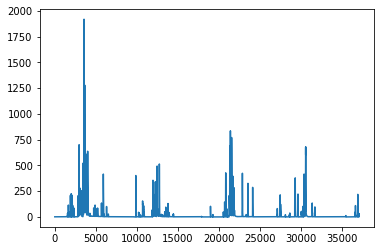

In [18]:
plt.figure()
plt.plot(Y_test_actual)
plt.show()

In [19]:
#Build Model
model = Sequential()
model.add(LSTM(units=24, return_sequences=True, 
               input_shape=(X_Train.shape[1],X_Train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 18, 24)            2688      
_________________________________________________________________
dropout (Dropout)            (None, 18, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                15000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 18,729
Trainable params: 18,729
Non-trainable params: 0
____________________________________________________

In [20]:
history = model.fit(X_Train, Y_Train, epochs=8,
                   validation_data=(X_Test, Y_Test))

Epoch 1/8
4638/4638 [==============================] - 77s 17ms/step - loss: 1.4318e-04 - val_loss: 8.0894e-05
Epoch 2/8
4638/4638 [==============================] - 75s 16ms/step - loss: 5.7359e-05 - val_loss: 5.2422e-05
Epoch 3/8
4638/4638 [==============================] - 75s 16ms/step - loss: 4.1674e-05 - val_loss: 5.1525e-05
Epoch 4/8
4638/4638 [==============================] - 76s 16ms/step - loss: 3.4856e-05 - val_loss: 1.9956e-05
Epoch 5/8
4638/4638 [==============================] - 75s 16ms/step - loss: 2.6493e-05 - val_loss: 1.6304e-05
Epoch 6/8
4638/4638 [==============================] - 75s 16ms/step - loss: 2.7245e-05 - val_loss: 1.7493e-05
Epoch 7/8
4638/4638 [==============================] - 75s 16ms/step - loss: 2.2837e-05 - val_loss: 1.6699e-05
Epoch 8/8
4638/4638 [==============================] - 76s 16ms/step - loss: 2.3229e-05 - val_loss: 2.2057e-05


In [21]:
weights = model.get_weights()

In [22]:
len(weights)

10

In [23]:
[weights[i].shape for i in range(len(weights))]

[(3, 96),
 (24, 96),
 (96,),
 (24, 200),
 (50, 200),
 (200,),
 (50, 20),
 (20,),
 (20, 1),
 (1,)]

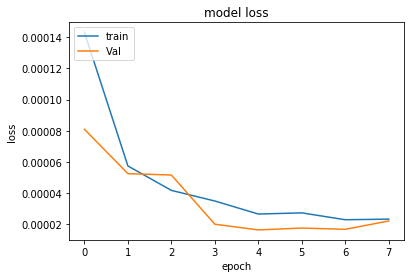

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [25]:
model.save("model2_waterflow.hdf5")

In [26]:
predicted_y_values = model.predict(X_Test)

In [27]:
predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)

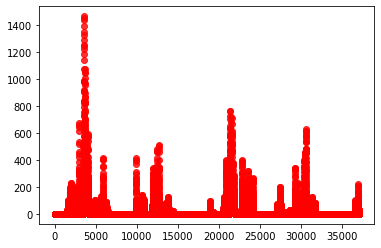

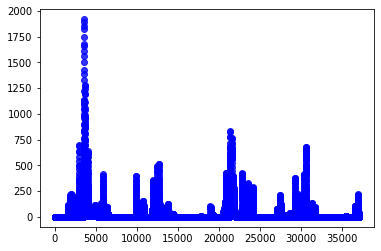

In [28]:
plt.figure()
plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
plt.show()
plt.figure()
plt.plot(Y_test_actual, 'bo', alpha=0.8)
plt.show()

In [29]:
max(predicted_y_values_unnor)

array([1465.3661], dtype=float32)

In [30]:
mean_square_root = mean_squared_error(predicted_y_values_unnor, Y_test_actual)
mean_square_root

140.9705764182873